In [3]:
#import necessary packages
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from tqdm import tqdm  
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from wordcloud import WordCloud
#load dataframe
df = pd.read_csv("Reviews.csv")

### Visualize data

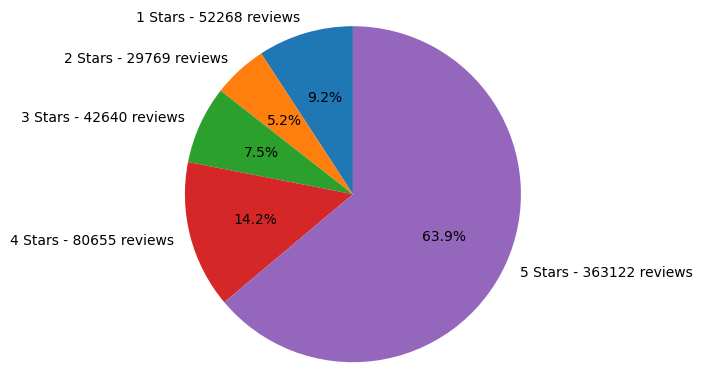

In [4]:
# count of total reviews by percentages

counts = df['Score'].value_counts().sort_index()
plt.pie(counts, labels=[f"{star} Stars - {counts[star]} reviews" for star in counts.index], autopct='%1.1f%%', startangle=90)
    
# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
plt.show()

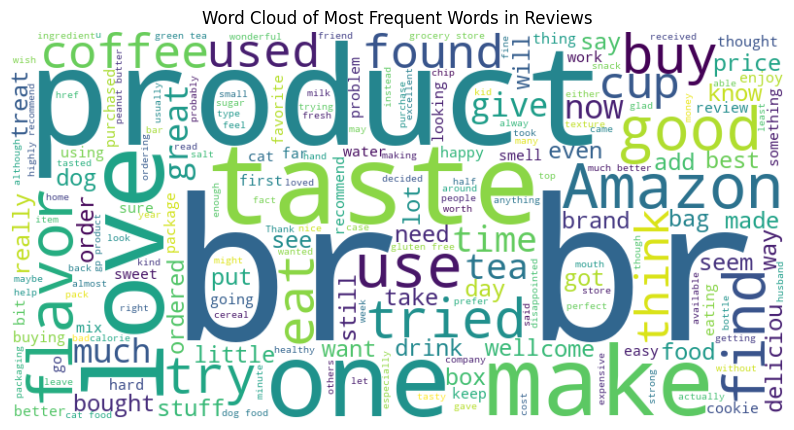

In [5]:
# Display a word cloud of the most frequent words in reviews
all_reviews = ' '.join(df['Text'])
wordcloud = WordCloud(width=798, height=400, max_words=200, background_color='white').generate(all_reviews)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words in Reviews')
plt.show()

### Get the overall sentiment of the data

In [6]:
df['sentiment'] = df['Score'].apply(lambda score: 
    'very negative' if score == 1 else
    'negative' if score == 2 else
    'neutral' if score == 3 else
    'positive' if score == 4 else
    'very positive' if score == 5 else 'unknown'
)
print(df['sentiment'])


0         very positive
1         very negative
2              positive
3              negative
4         very positive
              ...      
568449    very positive
568450         negative
568451    very positive
568452    very positive
568453    very positive
Name: sentiment, Length: 568454, dtype: object


### Preproccess the text

In [7]:
# Download NLTK stopwords and initialize the stemmer
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    if isinstance(text, str) and len(text) > 0:
        text = text.lower()
        #tokenize the text
        tokens = nltk.word_tokenize(text, preserve_line=True)
        tokens = [word for word in tokens if word.isalnum()]
        #remove stop words and apply the stemmer
        tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
        # Join tokens back into a string
        text = ' '.join(tokens)
        
        return text
    else:
        return ""

[nltk_data] Downloading package stopwords to C:\Users\Tom
[nltk_data]     O'Connor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
if os.path.exists('cleaned_dataframe.csv'):
    df = pd.read_csv('cleaned_dataframe.csv')
else:
    tqdm.pandas()
    #apply preprocessing to text
    df['cleaned_reviews'] = df['Text'].progress_apply(preprocess_text)
    df.to_csv('cleaned_dataframe.csv', index=False)


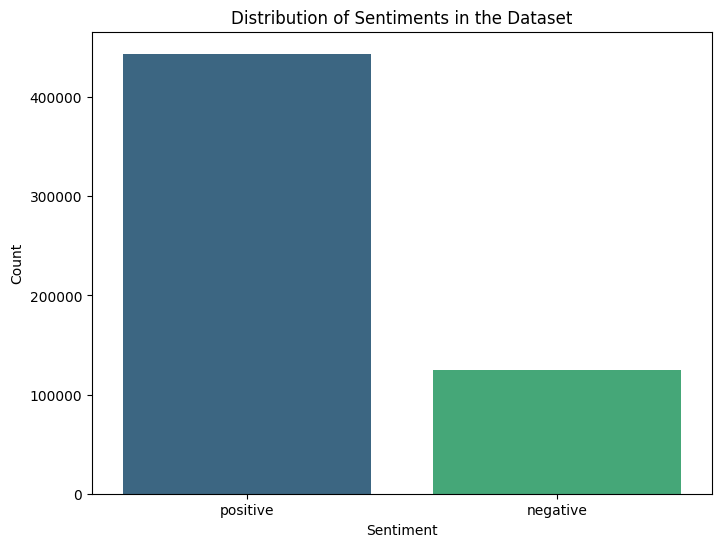

In [9]:
# Visualize distribution of sentiments
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, order=df['sentiment'].value_counts().index, palette='viridis')
plt.title('Distribution of Sentiments in the Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [10]:
np.random.seed(42)
# Set the number of data points you want to randomly select

X = df['cleaned_reviews']
y = df['Score']
#split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.values
X_test = X_test.values
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
len(X_train), len(y_train), len(X_test), len(y_test)

(454763, 454763, 113691, 113691)

### Set Device 

In [11]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

### Vectorize data

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### Make model

In [13]:

class SentimentAnalysisModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.5):
        super(SentimentAnalysisModel, self).__init__()
        
        # First hidden layer
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate)
        
        # Second hidden layer
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_rate)
        
        # Output layer
        self.layer3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.layer3(x)
        
        return x


### Make DataLoader

In [14]:
train_data = TensorDataset(torch.from_numpy(X_train_tfidf.toarray()).float(), torch.from_numpy(y_train))
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_data = TensorDataset(torch.from_numpy(X_test_tfidf.toarray()).float(), torch.from_numpy(y_test))
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [15]:
input_size = 5000
hidden_size1 = 512
hidden_size2 = 256
#make output size for star ratings
output_size = 6
model = SentimentAnalysisModel(input_size, hidden_size1, hidden_size2, output_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Train and test the model

In [16]:

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    train_predictions = []
    train_true_labels = []

    for batch, (X, y) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        X, y = X.to(device), y.to(device, dtype=torch.long)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += accuracy_score(y.cpu().numpy(), y_pred_class.cpu().numpy())
        train_predictions.extend(y_pred_class.cpu().numpy())
        train_true_labels.extend(y.cpu().cpu().numpy())

    train_f1 = f1_score(train_true_labels, train_predictions, average='weighted')

    model.eval() 
    test_loss, test_acc = 0, 0
    test_predictions = []
    test_true_labels = []
    test_positivity_correct = 0  # Counter for correctly predicted positive sentiments
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(tqdm(test_loader, desc=f'Test')):
            X, y = X.to(device), y.to(device, dtype=torch.long)
            test_pred = model(X)
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            test_pred_labels = test_pred.argmax(dim=1)
            test_acc += accuracy_score(y.cpu().numpy(), test_pred_labels.cpu().numpy())
            test_predictions.extend(test_pred_labels.cpu().numpy())
            test_true_labels.extend(y.cpu().cpu().numpy())
            
            # Check if predicted sentiment is positive
            predicted_positive = (test_pred_labels >= 4)
            true_positive = (y >= 4)
            test_positivity_correct += torch.sum(predicted_positive == true_positive).item()

    test_f1 = f1_score(test_true_labels, test_predictions, average='weighted')
    positivity_accuracy = test_positivity_correct / len(test_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train_Loss: {train_loss/len(train_loader):.4f}, Train_Acc: {train_acc/len(train_loader):.4f}, Train f1: {train_f1:.4f}, '
          f'Test_Loss: {test_loss/len(test_loader):.4f}, Test_Acc: {test_acc/len(test_loader):.4f}, Test_f1: {test_f1:.4f}, Positivity_Accuracy: {positivity_accuracy:.4f}')



Epoch 1/10:   0%|          | 0/3553 [00:00<?, ?it/s]

Test: 100%|██████████| 889/889 [00:03<00:00, 263.91it/s]


Epoch [1/10], Train_Loss: 0.7856, Train_Acc: 0.7144, Train f1: 0.6656, Test_Loss: 0.7076, Test_Acc: 0.7438, Test_f1: 0.7083, Positivity_Accuracy: 0.8958


Test: 100%|██████████| 889/889 [00:03<00:00, 236.52it/s]


Epoch [2/10], Train_Loss: 0.6620, Train_Acc: 0.7643, Train f1: 0.7379, Test_Loss: 0.6411, Test_Acc: 0.7740, Test_f1: 0.7477, Positivity_Accuracy: 0.9100


Test: 100%|██████████| 889/889 [00:03<00:00, 260.47it/s]


Epoch [3/10], Train_Loss: 0.5567, Train_Acc: 0.8036, Train f1: 0.7877, Test_Loss: 0.6037, Test_Acc: 0.7899, Test_f1: 0.7703, Positivity_Accuracy: 0.9161


Test: 100%|██████████| 889/889 [00:03<00:00, 259.63it/s]


Epoch [4/10], Train_Loss: 0.4761, Train_Acc: 0.8332, Train f1: 0.8228, Test_Loss: 0.5928, Test_Acc: 0.7973, Test_f1: 0.7805, Positivity_Accuracy: 0.9167


Test: 100%|██████████| 889/889 [00:03<00:00, 257.73it/s]


Epoch [5/10], Train_Loss: 0.4187, Train_Acc: 0.8524, Train f1: 0.8451, Test_Loss: 0.6049, Test_Acc: 0.8019, Test_f1: 0.7866, Positivity_Accuracy: 0.9193


Test: 100%|██████████| 889/889 [00:03<00:00, 256.83it/s]


Epoch [6/10], Train_Loss: 0.3738, Train_Acc: 0.8673, Train f1: 0.8620, Test_Loss: 0.6232, Test_Acc: 0.8051, Test_f1: 0.7896, Positivity_Accuracy: 0.9185


Test: 100%|██████████| 889/889 [00:03<00:00, 279.23it/s]


Epoch [7/10], Train_Loss: 0.3376, Train_Acc: 0.8797, Train f1: 0.8758, Test_Loss: 0.6300, Test_Acc: 0.8071, Test_f1: 0.7948, Positivity_Accuracy: 0.9194


Test: 100%|██████████| 889/889 [00:03<00:00, 258.79it/s]


Epoch [8/10], Train_Loss: 0.3065, Train_Acc: 0.8907, Train f1: 0.8878, Test_Loss: 0.6488, Test_Acc: 0.8093, Test_f1: 0.7966, Positivity_Accuracy: 0.9200


Test: 100%|██████████| 889/889 [00:03<00:00, 256.86it/s]


Epoch [9/10], Train_Loss: 0.2816, Train_Acc: 0.8993, Train f1: 0.8971, Test_Loss: 0.6776, Test_Acc: 0.8107, Test_f1: 0.7981, Positivity_Accuracy: 0.9196


Test: 100%|██████████| 889/889 [00:03<00:00, 262.11it/s]


Epoch [10/10], Train_Loss: 0.2594, Train_Acc: 0.9070, Train f1: 0.9053, Test_Loss: 0.7012, Test_Acc: 0.8103, Test_f1: 0.7996, Positivity_Accuracy: 0.9193


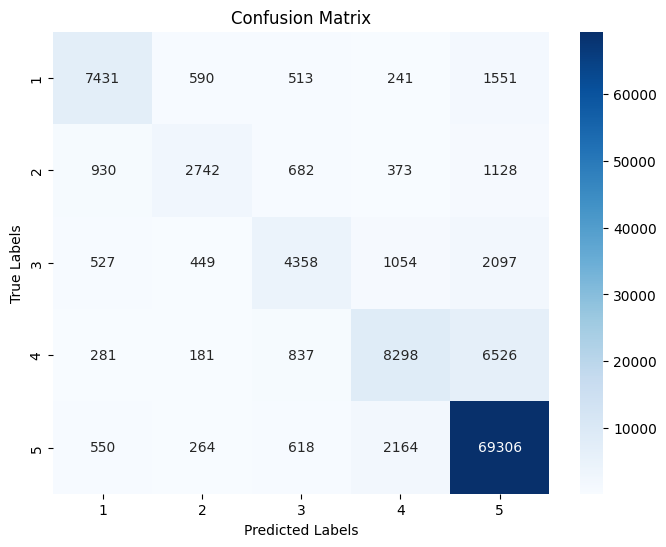

In [17]:
# Set the model to evaluation mode
model.eval()

# Initialize the lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

with torch.inference_mode():
    for batch, (X, y) in enumerate(test_loader):
        X, y = X.to(device), y.to(device, dtype=torch.long)
        test_pred = model(X)
        test_pred_labels = test_pred.argmax(dim=1)

        true_labels.extend(y.cpu().cpu().numpy())
        predicted_labels.extend(test_pred_labels.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
class_labels = [1, 2, 3, 4, 5]
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


The model seems to do fairly well because all true label and predicted label intersections are the highest value in their rows and columns. The model apperas to struggle most with 4 star reviews since 5 star reviews dominated the dataset and 4 stars is the closest.

In [18]:
# Add a new cell for user input
user_input = input("Enter a text for sentiment analysis: ")

# Preprocess the user input
cleaned_input = preprocess_text(user_input)

# Convert the input to TF-IDF features
user_input_tfidf = tfidf_vectorizer.transform([cleaned_input])

# Convert to PyTorch tensor and move to the appropriate device
user_input_tensor = torch.from_numpy(user_input_tfidf.toarray()).float().to(device)

# Make predictions using the trained model
with torch.inference_mode():
    model.eval()
    user_pred = model(user_input_tensor)
    user_pred_label = torch.argmax(user_pred).item()

# Map the predicted label to sentiment
sentiment_mapping = {
    1: 'very negative',
    2: 'negative',
    3: 'neutral',
    4: 'positive',
    5: 'very positive'
}
predicted_sentiment = sentiment_mapping[user_pred_label]

# Display the predicted sentiment
print(f"The predicted sentiment for the input text {user_input} is: {predicted_sentiment}")


The predicted sentiment for the input text The product is alright is: neutral
